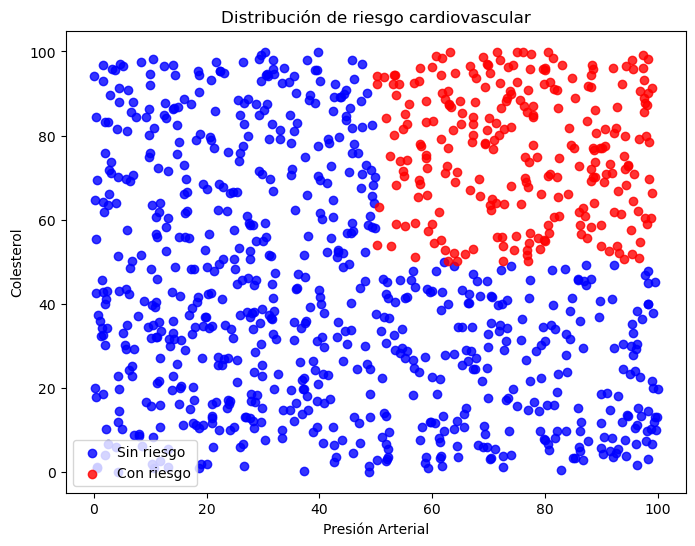

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generamos datos sintéticos
np.random.seed(0)
X = np.random.rand(1000, 2) * 100  # presión arterial y colesterol entre 0 y 100

# Etiquetas: riesgo si ambos > 50
y = (X[:, 0] > 50) & (X[:, 1] > 50)

# Gráfica de distribución
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Sin riesgo', alpha=0.8)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Con riesgo', alpha=0.8)
plt.xlabel('Presión Arterial')
plt.ylabel('Colesterol')
plt.title('Distribución de riesgo cardiovascular')
plt.legend()
plt.show()


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Separación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento del modelo
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
clf.fit(X_train_scaled, y_train)



MLPClassifier(hidden_layer_sizes=(5, 2), max_iter=1000, random_state=1,
              solver='lbfgs')

In [3]:
# Crear dos ejemplos nuevos: [presión, colesterol]
ejemplos_nuevos = np.array([[60, 60], [90, 40]])  # uno con alto riesgo, otro sin riesgo

# Escalar usando el mismo scaler
ejemplos_nuevos_scaled = scaler.transform(ejemplos_nuevos)

# Predecir
predicciones = clf.predict(ejemplos_nuevos_scaled)

# Mostrar resultados
for i, p in enumerate(predicciones):
    print(f"Ejemplo {i+1} => Presión: {ejemplos_nuevos[i,0]}, Colesterol: {ejemplos_nuevos[i,1]} => Predicción: {'Riesgo' if p else 'No riesgo'}")


Ejemplo 1 => Presión: 60, Colesterol: 60 => Predicción: Riesgo
Ejemplo 2 => Presión: 90, Colesterol: 40 => Predicción: No riesgo


## Parte 1 SHAP

Instancia #3
Presión Arterial: 62.67, Colesterol: 72.75
Valor real      : Riesgo
Predicción      : Riesgo
Probabilidad de riesgo: 1.000


  0%|          | 0/1 [00:00<?, ?it/s]

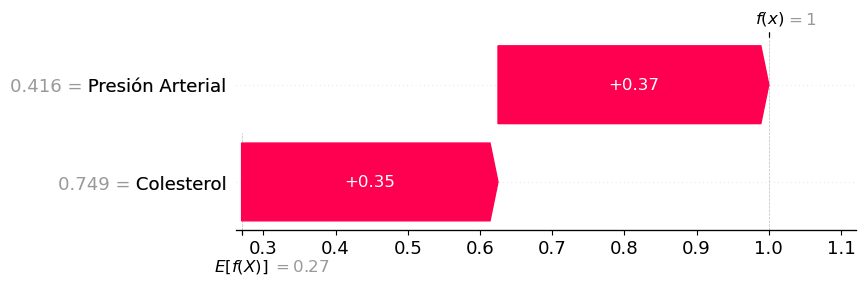

In [4]:
import pandas as pd
import shap

# --- Parte de impresión y predicción de la instancia ---
indice = 3  # 3 riesgo, 4 no riesgo
ejemplo = X_test[indice].reshape(1, -1)  # Mantener forma 2D
ejemplo_scaled = scaler.transform(ejemplo)

# Predicción y probabilidades
pred = clf.predict(ejemplo_scaled)
prob = clf.predict_proba(ejemplo_scaled)

# Imprimir resultados de la instancia
print(f"Instancia #{indice}")
print(f"Presión Arterial: {ejemplo[0, 0]:.2f}, Colesterol: {ejemplo[0, 1]:.2f}")
print(f"Valor real      : {'Riesgo' if y_test[indice] else 'No riesgo'}")
print(f"Predicción      : {'Riesgo' if pred[0] else 'No riesgo'}")
print(f"Probabilidad de riesgo: {prob[0][1]:.3f}")

# --- Parte de SHAP ---
# Definir nombres de las features y convertir los datos escalados a DataFrames
feature_names = ['Presión Arterial', 'Colesterol']
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Usar un subconjunto del conjunto de entrenamiento como fondo
background = X_train_df.sample(100, random_state=1)

# Crear el KernelExplainer en el espacio de margen (log‑odds)
explainer = shap.KernelExplainer(clf.predict_proba, background, model_output="margin")

# Extraer la instancia a explicar en formato DataFrame
ejemplo_df = X_test_df.iloc[[indice]]

# Calcular los valores SHAP para la instancia
shap_values = explainer(ejemplo_df)

# En un modelo binario, shap_values tendrá forma (n_instancias, 2, n_features).
# Para obtener la explicación para la clase "riesgo" (índice 1), usamos la indexación con ellipsis:
shap_value_riesgo = shap_values[..., 1]
shap_value_riesgo = shap_value_riesgo[0]  # Extraer la única explicación

# Mostrar la gráfica waterfall para la clase "riesgo"
shap.plots.waterfall(shap_value_riesgo)

## Análisis del gráfico SHAP

El gráfico SHAP muestra la contribución individual de cada variable a la predicción final del modelo. En este contexto, estamos analizando una instancia que fue clasificada como "Riesgo" con una probabilidad de 1.000, es decir, el modelo está completamente seguro de esta predicción.

- Los valores SHAP indican cuánto contribuye cada característica a alejar la predicción de la media del modelo (E[f(X)]) y acercarla al valor final (f(x)).

- Un valor SHAP positivo implica que la variable está empujando la predicción hacia la clase 1 (Riesgo).

- Un valor SHAP negativo indica que la variable está empujando la predicción hacia la clase 0 (No riesgo).


Interpretación específica de esta instancia:

- Presión Arterial (valor escalado: 0.416) tiene un valor SHAP de +0.37.

- Colesterol (valor escalado: 0.749) tiene un valor SHAP de +0.35.

Esto significa que:

- Ambas variables están contribuyendo a aumentar la probabilidad de riesgo (ya que ambos valores SHAP son positivos).

- Aunque no son exactamente iguales, ambas tienen un impacto similar en magnitud, lo que indica que el modelo considera que tanto la presión arterial como el colesterol son importantes para determinar el riesgo en este caso.

- La predicción base del modelo (E[f(X)]) es 0.27, y gracias a los aportes de estas dos variables, la predicción se incrementa hasta 1.0, es decir, riesgo total.

## Parte 2 ALE

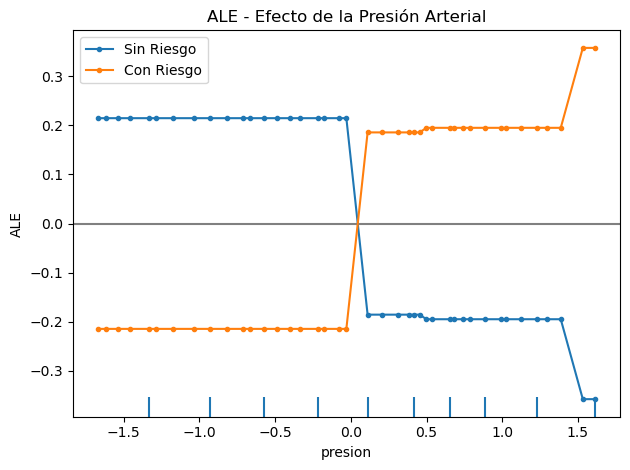

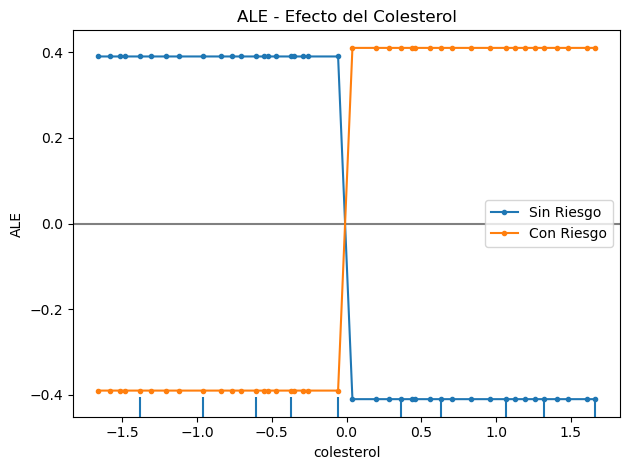

In [5]:
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale
import matplotlib.pyplot as plt
import numpy as np

# Crear el explicador ALE
feature_names = ['presion', 'colesterol']
ale_explainer = ALE(predictor=clf.predict_proba, feature_names=feature_names, target_names=['Sin Riesgo', 'Con Riesgo'])

# Definir los puntos de la cuadrícula para cada feature
grid_points = {
    'presion': np.linspace(X_test_scaled[:, 0].min(), X_test_scaled[:, 0].max(), num=20), # coge el mas pequeño y el mas grande de la feature y genera 20 puntos entre ellos
    'colesterol': np.linspace(X_test_scaled[:, 1].min(), X_test_scaled[:, 1].max(), num=20)
}

# Generar explicación ALE
ale_exp = ale_explainer.explain(X_test_scaled, grid_points=grid_points)

# Visualizar efecto de la presión arterial
plot_ale(ale_exp, features=['presion'])
plt.title('ALE - Efecto de la Presión Arterial')
plt.show()

# Visualizar efecto del colesterol
plot_ale(ale_exp, features=['colesterol'])
plt.title('ALE - Efecto del Colesterol')
plt.show()


Presión Arterial

Clase "Con Riesgo" (naranja):
  - Cuando la presión es baja, el efecto sobre la predicción es casi nulo.
  - A partir de un valor cercano a 0 (valor medio) el correspondiente a 50 sobre 100, el modelo comienza a asociar presión alta con mayor riesgo.
  - La subida al final es un poco extraña, cambiando la seed al general el dataset no aparece

Clase "Sin Riesgo" (azul):
  - A medida que sube la presión, la probabilidad de ser clasificado como "Sin Riesgo" disminuye.
  - Para valores bajos, el efecto es plano.

Conclusión: La presión arterial alta es un fuerte indicador de riesgo según el modelo.

Colesterol

Clase "Con Riesgo" (naranja):
  - El colesterol bajo no afecta mucho la predicción.
  - Alrededor del punto 0 (valor medio) el correspondiente a 50 sobre 100, el modelo comienza a asociar colesterol alto con riesgo.

Clase "Sin Riesgo" (azul):
  - Efecto negativo fuerte a partir del punto 0.
  - Es decir, a mayor colesterol, menor probabilidad de que el modelo prediga "Sin Riesgo".

Conclusión: El colesterol es otro fuerte indicador de riesgo según el modelo.


## Parte 3 LIME

In [6]:
from lime.lime_tabular import LimeTabularExplainer

# Creamos el objeto explicador de LIME usando los datos de entrenamiento escalados
lime_explainer = LimeTabularExplainer(
    training_data = X_train_scaled,
    feature_names = feature_names,
    class_names = ['Sin Riesgo', 'Con Riesgo'],
    mode = 'classification',
    discretize_continuous = True  # Discretiza variables continuas para facilitar la interpretación
)


In [7]:
# Seleccionamos una única instancia del conjunto de prueba para explicar (por ejemplo, la primera)
indice = 3 # 3 riesgo, 4 no riesgo
ejemplo = X_test[indice].reshape(1, -1)  # Mantener forma 2D
ejemplo_scaled = scaler.transform(ejemplo)

# Generamos la explicación para la instancia seleccionada usando la función predict_proba del modelo
lime_exp = lime_explainer.explain_instance(
    data_row = X_test_scaled[indice],
    predict_fn = clf.predict_proba,
    num_features = len(feature_names)  # Mostramos la importancia de todas las características
)

valor_real = y_test[indice]

print(f"Instancia #{indice}")
print(f"Presión Arterial: {ejemplo[0, 0]:.2f}, Colesterol: {ejemplo[0, 1]:.2f}")
# Mostrar la predicción: probabilidades, clase predicha y el valor real (si está disponible)
pred_proba = clf.predict_proba(ejemplo_scaled)[0]
pred_class = clf.predict(ejemplo_scaled)[0]
print("Probabilidades de cada clase:", pred_proba)
print("Predicción del modelo:", pred_class)
# Suponiendo que y_test ya esté definido y tenga índices compatibles:
print("Valor real:", valor_real)


Instancia #3
Presión Arterial: 62.67, Colesterol: 72.75
Probabilidades de cada clase: [2.68024505e-08 9.99999973e-01]
Predicción del modelo: True
Valor real: True


[('-0.01 < presion <= 0.89', 0.3598817926505375), ('-0.03 < colesterol <= 0.91', 0.35108343977782147)]


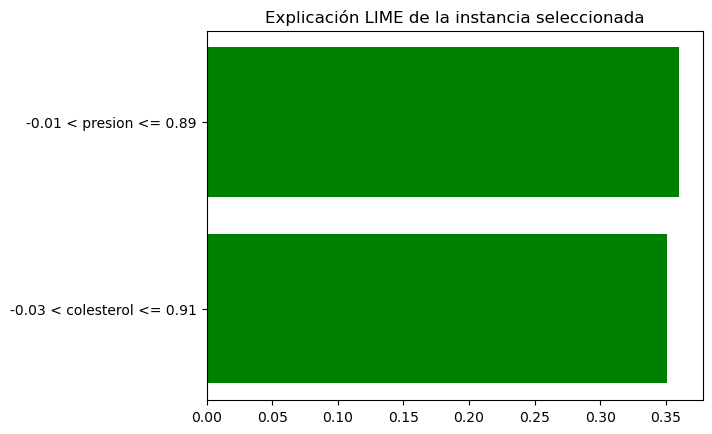

In [8]:

# Imprime en consola la lista con la influencia de cada característica
print(lime_exp.as_list())

# Generar y mostrar la gráfica de barras que indica la contribución de cada característica
fig = lime_exp.as_pyplot_figure()
plt.title("Explicación LIME de la instancia seleccionada")
plt.show()


si, la explicacion de lime concuerda con el resultado real ya que aqui en la instancia 3 muestra como las dos variables afectan positivamente para el riesgo 
y en la instancia 4 que es No riesgo la presion sale en rojo indicando que "resta" la probabilidad de riesgo y el colesterol le "suma" pero es mas greande lo que afecta la presion en negativo que
el colesterol en positivo por lo que indicaria que no hay riesgo

In [9]:
# Extraer la lista de explicaciones obtenida por LIME
lime_exp_list = lime_exp.as_list()

# Inicializar las variables para almacenar el impacto de 'colesterol' y 'presion'
colesterol_impact = None
presion_impact = None

# Buscar en la lista el impacto correspondiente a cada atributo (buscando palabras clave)
for feature, impact in lime_exp_list:
    if 'colesterol' in feature.lower():
        colesterol_impact = impact
    if 'presion' in feature.lower():
        presion_impact = impact

print("Impacto del colesterol en la predicción:", colesterol_impact)
print("Impacto de la presión arterial en la predicción:", presion_impact)


Impacto del colesterol en la predicción: 0.35108343977782147
Impacto de la presión arterial en la predicción: 0.3598817926505375


Tanto el colesterol como la presion afectan por igual, sus dos indices de impacto son extremadamente similares: 0:36... 
Esto tiene sentido ya que con nuestro dataset artificial hemos puesto que necesita que los dos sean mayores de 50 es decir que las dos variables son importantes por igual

## Parte 4 DiCE

a) Generación de contraejemplos 

In [30]:
import dice_ml
from dice_ml.utils import helpers

# Índice de la instancia a explicar
# Por ejemplo, usa índice 4 si la instancia original es "no riesgo" y deseas generar contraejemplos hacia "riesgo"
indice = 3  # 3 riesgo, 4 no riesgo

# Crear un DataFrame con los datos originales (no escalados)
df = pd.DataFrame(X, columns=["Presión Arterial", "Colesterol"])
df["No riesgo"] = y

# Crear el objeto de datos para DiCE basado en el DataFrame original
d = dice_ml.Data(dataframe=df, 
                 continuous_features=["Presión Arterial", "Colesterol"], 
                 outcome_name="No riesgo")

# Crear el objeto modelo para DiCE utilizando el modelo entrenado.
# Nota: clf fue entrenado con datos escalados, pero aquí usamos el DataFrame en escala original
m = dice_ml.Model(model=clf, backend="sklearn")

# Inicializar la explicación con DiCE (método "random")
exp = dice_ml.Dice(d, m, method="random")

# Seleccionar la instancia a explicar. Se extrae de los datos originales (X_test) en escala original.
query_instance_original = pd.DataFrame(
    X_test[indice].reshape(1, -1), 
    columns=["Presión Arterial", "Colesterol"]
)

print("Instancia original a explicar (valores en escala original):")
print(query_instance_original)


Instancia original a explicar (valores en escala original):
   Presión Arterial  Colesterol
0         62.670648   72.754361


b) Análisis de los contraejemplos

In [31]:
# Generar contraejemplos (CFs) para la instancia seleccionada
cf = exp.generate_counterfactuals(query_instance_original, total_CFs=3, desired_class="opposite")

# Visualizar los contraejemplos en forma de DataFrame
cf.visualize_as_dataframe()



  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\jorge\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\jorge\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\jorge\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\jorge\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\jorge\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
c:\Users\jorge\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted withou

Query instance (original outcome : False)


,Presión Arterial,Colesterol,No riesgo
0,62.670647,72.754364,False



Diverse Counterfactual set (new outcome: True)


,Presión Arterial,Colesterol,No riesgo
0,5.897085,17.449269,True
1,1.079246,11.995926,True
2,1.306835,4.210814,True


Al observar los 3 contraejemplos, podemos concluir:
- Todos los contraejemplos tienen valores muy reducidos de presion arterial respecto a la instancia original
- Todos los contraejemplos tienen valores reducidos de colesterol respecto a la instancia original
- Da a entender que lo que tiene que hacer para mejorar es bajar tanto la presion como el colesterol
- Aun asi nos parece que son datos muy reducidos no sabemos si esto se puede deber a algún error quizas es por pasarle al modelo los datos escalados para entrenarlo y en el DICE no por que salian datos muy bajos y dificilmente interpretables

# Conclusiones finales

Tras aplicar loos métodos SHAP, ALE, LIME y DiCE sobre nuestro modelo para detectar problemas cardiovasculares, podemos concluir:

## ¿Concuerdan las diferentes explicaciones entre ellas?

Sí, las explicaciones ofrecidas por los distintos métodos concuerdan entre sí. Todos identifican que el colesterol es el atributo más relevante en la predicción de un posible problema cardiovascular, que la presión arterial también influye en la predicción (pero en menor medida) y que la instancia analizada fue correctamente clasificada como un caso de problema cardiovascular. 

## ¿Qué diferencias hay entre los diferentes tipos de explicaciones ofrecidas y cuáles son más adecuadas para explicar unos tipos de problemas u otros?

SHAP proporciona explicaciones de tipo local basadas en la teoría de los valores de Shapley. Este método analiza el impacto individual de cada característica sobre la predicción de una instancia concreta, calculando cómo varía la salida del modelo al incluir o excluir dicha característica. Es uno de los enfoques más rigurosos y matemáticamente sólidos, y permite visualizar con gran detalle cómo cada variable contribuye de forma positiva o negativa al resultado. Puede resultar altamente costoso.



ALE se centra en medir el efecto marginal de una característica en la predicción de un modelo, controlando la influencia de otras variables. A diferencia de SHAP, que considera todas las posibles interacciones, ALE aísla el efecto de una variable específica, lo que lo hace más robusto ante correlaciones entre características. Este método es especialmente útil para explicaciones globales, es decir, para entender cómo una variable afecta generalmente las predicciones del modelo en todo el conjunto de datos. Su enfoque lo hace menos propenso a interpretaciones erróneas en presencia de dependencias entre variables, pero no proporciona el mismo nivel de detalle a nivel individual que SHAP. Es ideal para análisis exploratorios y para entender relaciones no lineales en modelos complejos, como en estudios de impacto económico o en ciencias ambientales.



LIME es un método que aproxima el comportamiento de un modelo complejo alrededor de una predicción específica mediante un modelo interpretable, como una regresión lineal o un árbol de decisión. Su principal ventaja es su flexibilidad, ya que puede aplicarse a cualquier tipo de modelo, independientemente de su arquitectura. Sin embargo, a diferencia de SHAP, sus explicaciones no son tan consistentes, ya que dependen de una aproximación local que puede variar según cómo se defina el entorno de la instancia analizada. LIME es especialmente útil cuando se necesita una explicación rápida y comprensible para usuarios no técnicos, como en sistemas de recomendación o análisis de sentimientos en redes sociales. Su simplicidad lo hace accesible, pero puede perder precisión en modelos con interacciones complejas entre variables.


DICE se enfoca en generar explicaciones contrafactuales, es decir, muestra qué cambios serían necesarios en las características de entrada para alterar la predicción del modelo. A diferencia de SHAP, LIME o ALE, que explican por qué un modelo tomó una decisión, DICE ayuda a entender cómo podría cambiarse esa decisión. Este enfoque es especialmente valioso en aplicaciones donde se busca proporcionar recomendaciones accionables, como en préstamos bancarios (ej.: "Si tu ingreso fuera un 10% mayor, tu solicitud sería aprobada"). Sin embargo, su principal limitación es que no cuantifica la contribución individual de cada variable, sino que ofrece escenarios alternativos. Es ideal para contextos donde se requiere guiar a los usuarios sobre cómo modificar sus inputs para obtener un resultado deseado, como en asesorías financieras o sistemas de selección de personal.



Como resumen de estas conclusiones finales, podemos decir que SHAP es el más adecuado cuando se necesita precisión matemática y explicaciones detalladas, mientras que ALE es mejor para analizar efectos marginales globales en presencia de variables correlacionadas. LIME es útil para explicaciones simples y rápidas, especialmente en modelos "black-box", y DICE destaca cuando el objetivo es proporcionar alternativas prácticas para modificar predicciones. La elección del método depende del contexto, el tipo de modelo y las necesidades específicas de interpretabilidad.